In [1]:
import os
import sys
import torch
import numpy as np
from typing import List, Dict, Tuple, Optional
from collections import defaultdict
from huggingface_hub import snapshot_download
from dictionary_learning.utils import load_dictionary
from transformers import AutoTokenizer, AutoModelForCausalLM
from nnsight import LanguageModel
import json


/root/reward_hacking_sae_dashboard/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Utility Functions


In [2]:
def load_sae(layer: int, trainer: int, sae_repo: str = "andyrdt/saes-gpt-oss-20b"):
    """Load SAE for a specific layer."""
    print(f"Loading SAE from {sae_repo}...")
    subfolder = f"resid_post_layer_{layer}/trainer_{trainer}"
    
    local_dir = snapshot_download(
        repo_id=sae_repo,
        allow_patterns=f"{subfolder}/*",
        local_dir_use_symlinks=False,
        cache_dir=None
    )
    
    final_path = os.path.join(local_dir, subfolder)
    sae, config = load_dictionary(final_path, device="cuda")
    sae.eval()
    
    print(f"  SAE loaded: {type(sae).__name__}")
    print(f"  Encoder shape: {sae.encoder.weight.shape}")
    return sae, config


def get_feature_encoders(sae, feature_ids: List[int]) -> torch.Tensor:
    """
    Extract encoder vectors for specific features.
    
    Returns:
        Tensor of shape (num_features, d_model)
    """
    encoder = sae.encoder.weight.detach()  # (n_features, d_model) - keep on CUDA
    feature_encoders = encoder[feature_ids]  # (num_features, d_model)
    return feature_encoders


## Weight-Based Attribution


In [11]:
import nnsight
from nnsight import LanguageModel

In [12]:
model = LanguageModel("openai/gpt-oss-20b")
tokenizer = AutoTokenizer.from_pretrained("openai/gpt-oss-20b")

In [13]:
sae, config = load_sae(15, 0)
feature_encoders = get_feature_encoders(sae, [71990])






Loading SAE from andyrdt/saes-gpt-oss-20b...
  SAE loaded: BatchTopKSAE
  Encoder shape: torch.Size([131072, 2880])


# Backward Attribution: What Writes to a Direction?

This notebook traces **backwards from layer 24** to see which components (attention heads, MLPs) write to a specific direction at each layer.

## The Key Idea

At each layer L:
```
residual[L] = residual[L-1] + attn[L] + mlp[L]
```

We can attribute our direction `d` by computing:
- `contribution_from_attn = d · attn[L]`
- `contribution_from_mlp = d · mlp[L]`
- `contribution_from_prev = d · residual[L-1]`

Going backwards tells us **where the direction is built up** across the network.


## Step 1: Define Your Direction Vector

You can use:
- An SAE feature encoder (like we loaded above)
- A steering vector
- Any custom direction of shape `[d_model]`


In [16]:
# Option 1: Use an SAE feature encoder as your direction
direction = feature_encoders[0]  # Shape: [d_model]
direction = direction.cuda()

# Option 2: Load a steering vector
# steering_vectors = torch.load("steering_vectors.pt")
# direction = steering_vectors[15].cuda()

# Option 3: Use a custom direction
# direction = torch.randn(2880).cuda()  # d_model for GPT-OSS-20B is 2880

print(f"Direction shape: {direction.shape}")
print(f"Direction norm: {direction.norm():.4f}")


Direction shape: torch.Size([2880])
Direction norm: 1.1584


## Step 2: Define Your Text Prompt

We need to run text through the model to see what components write.


In [17]:
text = "The quick brown fox jumps over the lazy dog"
# text = "Your custom text here"

tokens = tokenizer.encode(text)
print(f"Text: {text}")
print(f"Tokens: {tokens}")
print(f"Num tokens: {len(tokens)}")


Text: The quick brown fox jumps over the lazy dog
Tokens: [976, 4853, 19705, 68347, 65613, 1072, 290, 29082, 6446]
Num tokens: 9


## Step 3: Attribution Function

This function takes a layer number and returns what writes to the direction at that layer.


In [20]:
model

GptOssForCausalLM(
  (model): GptOssModel(
    (embed_tokens): Embedding(201088, 2880, padding_idx=199999)
    (layers): ModuleList(
      (0-23): 24 x GptOssDecoderLayer(
        (self_attn): GptOssAttention(
          (q_proj): Linear(in_features=2880, out_features=4096, bias=True)
          (k_proj): Linear(in_features=2880, out_features=512, bias=True)
          (v_proj): Linear(in_features=2880, out_features=512, bias=True)
          (o_proj): Linear(in_features=4096, out_features=2880, bias=True)
        )
        (mlp): GptOssMLP(
          (router): GptOssTopKRouter()
          (experts): GptOssExperts()
        )
        (input_layernorm): GptOssRMSNorm((2880,), eps=1e-05)
        (post_attention_layernorm): GptOssRMSNorm((2880,), eps=1e-05)
      )
    )
    (norm): GptOssRMSNorm((2880,), eps=1e-05)
    (rotary_emb): GptOssRotaryEmbedding()
  )
  (lm_head): Linear(in_features=2880, out_features=201088, bias=False)
  (generator): WrapperModule()
)

## Step 4: Test on a Single Layer

Let's first test on one layer to see how it works.


In [19]:
# Test on layer 15
results = attribute_at_layer(model, text, layer_idx=15, direction=direction)

print(f"\n{'='*60}")
print(f"LAYER 15 - Component Contributions")
print(f"{'='*60}")

for component, stats in results['contributions'].items():
    print(f"\n{component.upper()}:")
    print(f"  Mean: {stats['mean']:8.4f}")
    print(f"  Std:  {stats['std']:8.4f}")
    print(f"  Max:  {stats['max']:8.4f}")
    print(f"  Min:  {stats['min']:8.4f}")

print(f"\n{'='*60}")
print(f"Per-Token Breakdown (first 5 tokens):")
print(f"{'='*60}")
for pos in range(min(5, len(results['per_token']))):
    token_data = results['per_token'][pos]
    token_text = tokenizer.decode([tokens[pos]])
    print(f"\nToken {pos} ('{token_text}'):")
    print(f"  Previous layers: {token_data['previous_layers']:8.4f}")
    print(f"  Attention:       {token_data['attention']:8.4f}")
    print(f"  MLP:             {token_data['mlp']:8.4f}")
    print(f"  Total:           {token_data['total']:8.4f}")
    print(f"  Sum check:       {token_data['verification_sum']:8.4f}")


ValueError: Could not find layers in model

## Step 6: Visualize Results

Let's create a summary table showing what writes to the direction at each layer.


NameError: name 'all_layer_results' is not defined

NameError: name 'df' is not defined

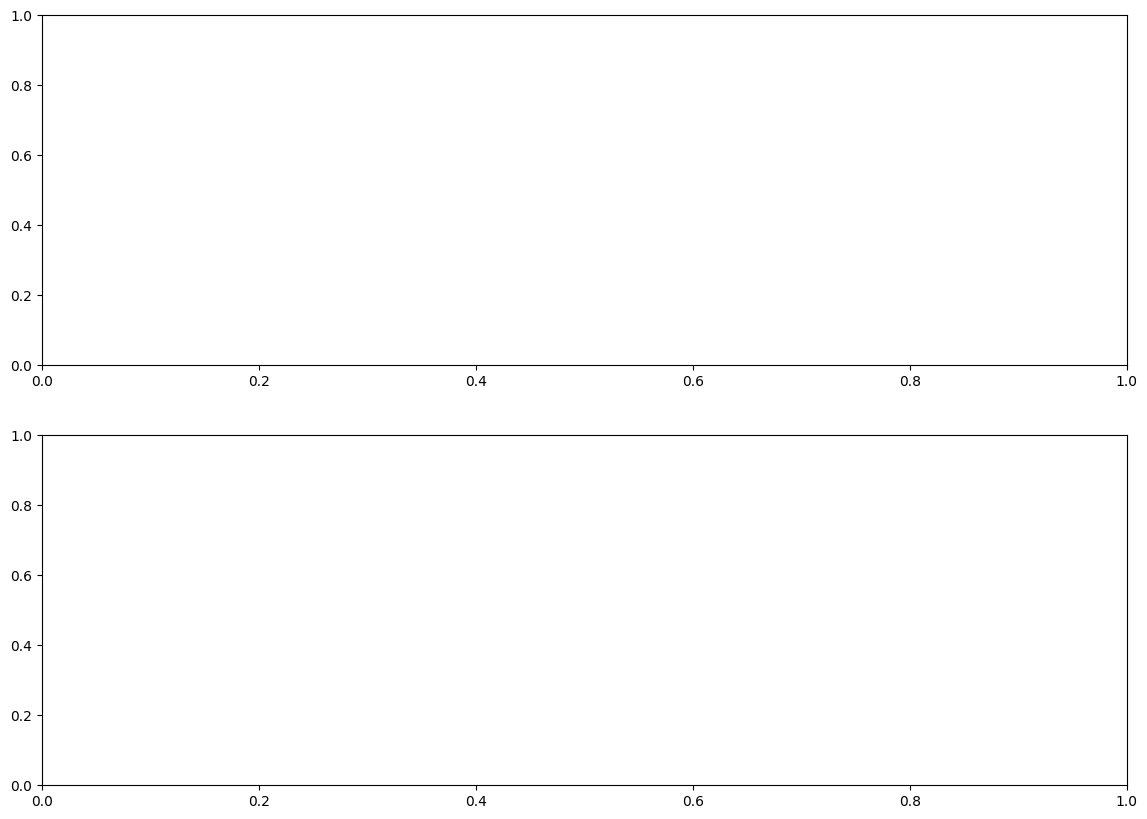

Head attribution function defined!


In [25]:
# Save results to JSON
output_data = {
    'text': text,
    'direction_norm': float(direction.norm().cpu()),
    'layers': {}
}

for layer_idx, result in all_layer_results.items():
    output_data['layers'][layer_idx] = result

with open('attribution_results.json', 'w') as f:
    json.dump(output_data, f, indent=2)

print("Results saved to: attribution_results.json")
print(f"\nAnalyzed {len(all_layer_results)} layers")
print(f"Text: {text}")


NameError: name 'all_layer_results' is not defined